In [1]:
# =========================================================
# IMPORTS
# =========================================================
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# =========================================================
# LOAD & CLEAN DATA
# =========================================================
def clean_solar_data(path):
    df = pd.read_csv(path)

    df['Time'] = pd.to_datetime(df['Time'], format='%d-%m-%Y %H:%M')
    df.set_index('Time', inplace=True)
    df = df.sort_index()

    # Remove duplicates
    df = df[~df.index.duplicated(keep='first')]

    # Fill missing timestamps (15-min intervals)
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq='15T')
    df = df.reindex(full_idx)

    # Interpolate missing values
    df['generation(kWh)'] = df['generation(kWh)'].interpolate().fillna(0)
    df['power(W)'] = df['power(W)'].interpolate().fillna(0)

    # Clip extreme outliers
    df['generation(kWh)'] = df['generation(kWh)'].clip(lower=0, upper=df['generation(kWh)'].quantile(0.999))
    df['power(W)'] = df['power(W)'].clip(lower=0, upper=df['power(W)'].quantile(0.999))

    return df

# =========================================================
# SLIDING WINDOW PREP
# =========================================================
def create_window_data(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

# =========================================================
# LOAD DATA
# =========================================================
df = clean_solar_data("Dataset.csv")   # <
print("Data loaded:", df.shape)

# =========================================================
# SCALING
# =========================================================
scaler = MinMaxScaler()
df['gen_scaled'] = scaler.fit_transform(df[['generation(kWh)']])

# Prepare input for only 1 variable (generation)
values = df['gen_scaled'].values

WINDOW = 96   # 96 = past 24 hours (96 × 15min)
X, y = create_window_data(values, WINDOW)

# reshape to (samples, window, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Train-test split
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)

# =========================================================
# BUILD TCN MODEL
# =========================================================
from tensorflow.keras.layers import Conv1D, BatchNormalization, ReLU, Add, Dense, Input

def TCN_block(x, filters, dilation):
    prev = x

    x = Conv1D(filters, kernel_size=3, padding="causal", dilation_rate=dilation)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv1D(filters, kernel_size=3, padding="causal", dilation_rate=dilation)(x)
    x = BatchNormalization()(x)

    # Residual connection
    if prev.shape[-1] != x.shape[-1]:
        prev = Conv1D(filters, kernel_size=1, padding="same")(prev)

    x = Add()([x, prev])
    x = ReLU()(x)
    return x

def build_tcn(input_shape):
    inputs = Input(shape=input_shape)

    x = TCN_block(inputs, 32, dilation=1)
    x = TCN_block(x, 32, dilation=2)
    x = TCN_block(x, 32, dilation=4)
    x = TCN_block(x, 32, dilation=8)

    x = layers.GlobalAveragePooling1D()(x)
    outputs = Dense(1)(x)

    return models.Model(inputs, outputs)

model = build_tcn((WINDOW, 1))
model.summary()

# =========================================================
# COMPILE
# =========================================================
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

# =========================================================
# CALLBACKS
# =========================================================
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        "tcn_best_model.keras",
        monitor='val_loss',
        save_best_only=True
    )
]

# =========================================================
# TRAIN MODEL
# =========================================================
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=32,
    callbacks=callbacks,
    verbose=2
)

# =========================================================
# EVALUATE
# =========================================================
preds = model.predict(X_val)
mse = mean_squared_error(y_val, preds)
print("Final Validation MSE:", mse)



C:\Users\Ojasvin\AppData\Local\Temp\ipykernel_18452\4166317413.py:26: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_idx = pd.date_range(df.index.min(), df.index.max(), freq='15T')


Data loaded: (75936, 2)
Train shape: (60672, 96, 1)
Val shape: (15168, 96, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 96, 32)    │        128 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 96, 32)    │        128 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 96, 32)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 96, 32)    │      3,104 │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 32)    │        128 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 96, 32)    │         64 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 96, 32)    │          0 │ batch_normalizat… │
│                     │                   │            │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 96, 32)    │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 96, 32)    │      3,104 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 32)    │        128 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 96, 32)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 96, 32)    │      3,104 │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 32)    │        128 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 96, 32)    │          0 │ batch_normalizat… │
│                     │                   │            │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 96, 32)    │          0 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 96, 32)    │      3,104 │ re_lu_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 32)    │        128 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 96, 32)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 96, 32)    │      3,104 │ re_lu_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 32)    │        128 │ conv1d_6[0][0]  

 Total params: 22,977 (89.75 KB)

 Trainable params: 22,465 (87.75 KB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/25
1896/1896 - 28s - 15ms/step - loss: 0.0100 - mae: 0.0604 - val_loss: 0.0036 - val_mae: 0.0392
Epoch 2/25
1896/1896 - 29s - 15ms/step - loss: 0.0043 - mae: 0.0429 - val_loss: 0.0042 - val_mae: 0.0458
Epoch 3/25
1896/1896 - 34s - 18ms/step - loss: 0.0038 - mae: 0.0400 - val_loss: 0.0024 - val_mae: 0.0296
Epoch 4/25
1896/1896 - 29s - 15ms/step - loss: 0.0036 - mae: 0.0381 - val_loss: 0.0030 - val_mae: 0.0320
Epoch 5/25
1896/1896 - 31s - 16ms/step - loss: 0.0034 - mae: 0.0365 - val_loss: 0.0049 - val_mae: 0.0583
Epoch 6/25
1896/1896 - 35s - 18ms/step - loss: 0.0032 - mae: 0.0353 - val_loss: 0.0032 - val_mae: 0.0391
Epoch 7/25
1896/1896 - 34s - 18ms/step - loss: 0.0031 - mae: 0.0341 - val_loss: 0.0055 - val_mae: 0.0613
Epoch 8/25
1896/1896 - 34s - 18ms/step - loss: 0.0030 - mae: 0.0333 - val_loss: 0.0040 - val_mae: 0.0455
Epoch 9/25
1896/1896 - 43s - 23ms/step - loss: 0.0030 - mae: 0.0338 - val_loss: 0.0054 - val_mae: 0.0537
Epoch 10/25
1896/1896 - 48s - 25ms/step - loss: 0.0029 

1896/1896 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


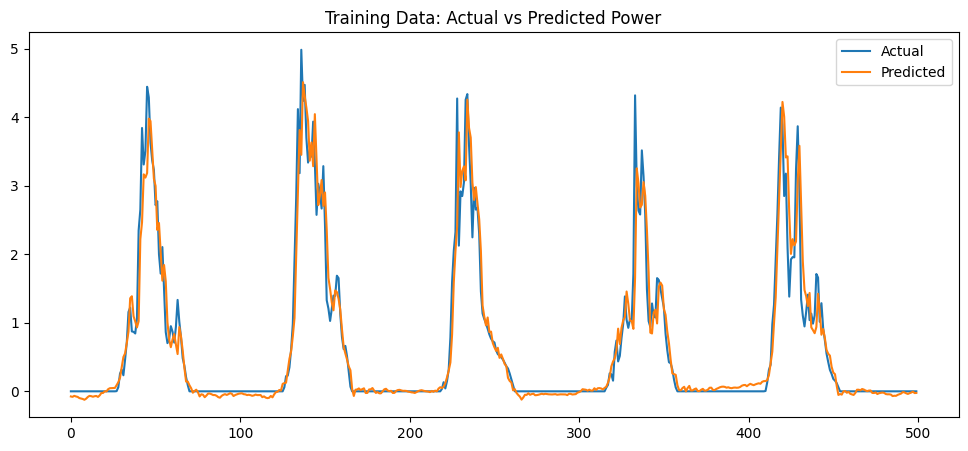

474/474 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


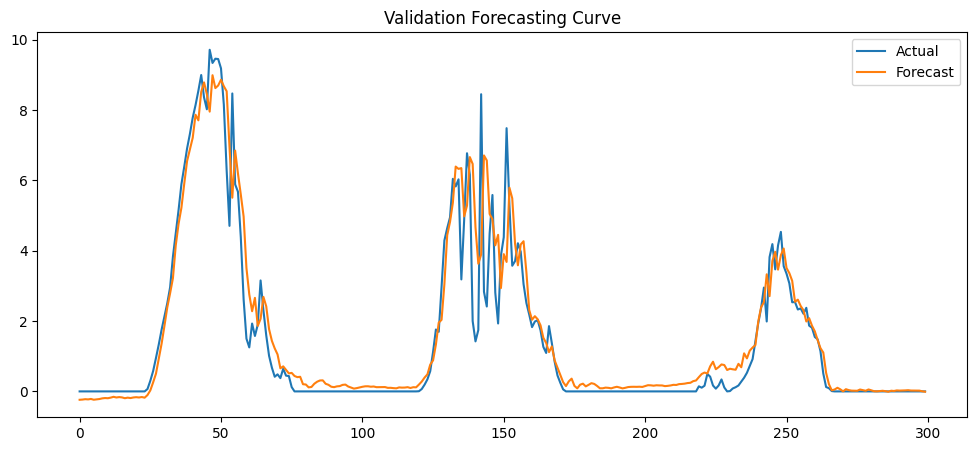

In [ ]:
# final
# ============================================================
# 8) RESCALE + PLOT TRAIN PREDICTIONS
# ============================================================
train_pred = model.predict(X_train)
train_pred_rescaled = scaler.inverse_transform(train_pred)
y_train_rescaled = scaler.inverse_transform(y_train.reshape(-1, 1))

plt.figure(figsize=(12,5))
plt.plot(y_train_rescaled[:500], label="Actual")
plt.plot(train_pred_rescaled[:500], label="Predicted")
plt.title("Training Data: Actual vs Predicted Power")
plt.legend()
plt.show()


# ============================================================
# 9) FORECAST VALIDATION SET
# ============================================================
val_pred = model.predict(X_val)
val_pred_rescaled = scaler.inverse_transform(val_pred)
y_val_rescaled = scaler.inverse_transform(y_val.reshape(-1, 1))

plt.figure(figsize=(12,5))
plt.plot(y_val_rescaled[:300], label="Actual")
plt.plot(val_pred_rescaled[:300], label="Forecast")
plt.title("Validation Forecasting Curve")
plt.legend()
plt.show()